# PyTorch Implementation (Structured Data Processing)

(Last updated: Jan 30, 2025)[^credit]

[^credit]: Credit: this teaching material is created by [Yen-Chia Hsu](https://github.com/yenchiah).

In this practice, we will guide you using the PyTorch deep learning framework to implement a deep regression model on the Smell Pittsburgh dataset. We only provide the basics in this notebook, and the following resources give more detailed information about PyTorch:
- [Introduction to PyTorch (Part 1), UvA Deep Learning Course](https://www.youtube.com/watch?v=wnKZZgFQY-E)
- [Introduction to PyTorch (Part 2), UvA Deep Learning Course](https://www.youtube.com/watch?v=schbjeU5X2g)
- [Deep Learning with PyTorch: A 60 Minute Blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)

:::{important}
To make this notebook work, you need to [install PyTorch](https://pytorch.org/get-started/locally/). You can also copy this notebook (as well as the dataset) to Google Colab and run the notebook on it.
:::

First, we begin importing the required packages.

In [1]:
import pandas as pd
import numpy as np
from os.path import isfile
from os.path import join
from os import listdir
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm

# Import the answers for the tasks
from util.answer import (
   answer_preprocess_sensor,
   answer_preprocess_smell,
   answer_sum_current_and_future_data
)

# Import the utility functions that are provided
from util.util import (
    convert_wind_direction,
    insert_previous_data_to_cols
)

Then, we need to set the resources that we want to use for computing. On a machine with a GPU (Graphics Processing Unit), we would prefer to use it since a GPU can speed up the computation a lot. On a MacOS computer with advanced chips (e.g., M1 or M2), PyTorch can use the [MPS backend](https://pytorch.org/docs/stable/notes/mps.html) to perform computing.

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda") # use CUDA device
elif torch.backends.mps.is_available():
    device = torch.device("mps") # use MacOS GPU device (e.g., for M2 chips)
else:
    device = torch.device("cpu") # use CPU device
device

device(type='mps')

The following code will help you move the data to the device that you choose.

In [3]:
def to_device(data, device):
    """Move PyTorch objects (e.g., tensors, models) to a chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

Below we hide the function for computing the features and labels, which is taken from the structured data processing tutorial.

In [4]:
def compute_feature_label(df_smell, df_sensor, b_hr_sensor=0, f_hr_smell=0):
    """
    Compute features and labels from the smell and sensor data.

    Parameters
    ----------
    df_smell : pandas.DataFrame
        The preprocessed smell data.
    df_sensor : pandas.DataFrame
        The preprocessed sensor data.
    b_hr_sensor : int
        Number of hours that we want to insert the previous sensor data.
    f_hr_smell : int
        Number of hours that we want to sum up the future smell data.

    Returns
    -------
    df_x : pandas.DataFrame
        The features that we want to use for modeling.
    df_y : pandas.DataFrame
        The labels that we want to use for modeling.
    """
    # Copy data frames to prevent editing the original ones.
    df_smell = df_smell.copy(deep=True)
    df_sensor = df_sensor.copy(deep=True)

    # Replace -1 values in sensor data to NaN
    df_sensor[df_sensor==-1] = np.nan

    # Convert all wind directions.
    df_sensor = convert_wind_direction(df_sensor)

    # Scale sensor data and fill in missing values
    df_sensor = (df_sensor - df_sensor.mean()) / df_sensor.std()
    df_sensor = df_sensor.round(6)
    df_sensor = df_sensor.fillna(-1)

    # Insert previous sensor data as features.
    # Noice that the df_sensor is already using the previous data.
    # So b_hr_sensor=0 means using data from the previous 1 hour.
    # And b_hr_sensor=n means using data from the previous n+1 hours.
    df_sensor = insert_previous_data_to_cols(df_sensor, b_hr_sensor)

    # Sum up current and future smell values as label.
    # Notice that the df_smell is already the data from the future 1 hour.
    # (as indicated in the preprocessing phase of smell data)
    # So f_hr_smell=0 means using data from the future 1 hour.
    # And f_hr_smell=n means using data from the future n+1 hours.
    df_smell = answer_sum_current_and_future_data(df_smell, f_hr_smell)

    # Add suffix to the column name of the smell data to prevent confusion.
    # See the description above for the reason of adding 1 to the f_hr_smell.
    df_smell.columns += "_future_" + str(f_hr_smell+1) + "h"

    # We need to first merge these two timestamps based on the available data.
    # In this way, we synchronize the time stamps in the sensor and smell data.
    # This also means that the sensor and smell data have the same number of data points.
    df = pd.merge_ordered(df_sensor.reset_index(), df_smell.reset_index(), on=df_smell.index.name, how="inner", fill_method=None)

    # Sanity check: there should be no missing data.
    assert df.isna().sum().sum() == 0, "Error! There is missing data."

    # Separate features (x) and labels (y).
    df_x = df[df_sensor.columns].copy()
    df_y = df[df_smell.columns].copy()

    # Add the hour of day and the day of week.
    dow_radian = df["EpochTime"].dt.dayofweek.copy(deep=True) * 2 * np.pi / 6.0
    tod_radian = df["EpochTime"].dt.hour.copy(deep=True) * 2 * np.pi / 23.0
    df_x.loc[:,"day_of_week_sine"] = np.sin(dow_radian)
    df_x.loc[:,"day_of_week_cosine"] = np.cos(dow_radian)
    df_x.loc[:,"hour_of_day_sine"] = np.sin(tod_radian)
    df_x.loc[:,"hour_of_day_cosine"] = np.cos(tod_radian)
    return df_x, df_y

Now, we need to load and preprocess the dataset using the code in the structured data processing tutorial.

In [5]:
# Load and preprocess sensor data
path = "smellpgh-v1/esdr_raw"
list_of_files = [f for f in listdir(path) if isfile(join(path, f))]
sensor_raw_list = []
for f in list_of_files:
    sensor_raw_list.append(pd.read_csv(join(path, f)).set_index("EpochTime"))
df_sensor = answer_preprocess_sensor(sensor_raw_list)

# Load and preprocess smell data
smell_raw = pd.read_csv("smellpgh-v1/smell_raw.csv").set_index("EpochTime")
df_smell = answer_preprocess_smell(smell_raw)

# Compute features and labels
df_x, df_y = compute_feature_label(df_smell, df_sensor, b_hr_sensor=2, f_hr_smell=7)

# Use value 40 as the threshold to indicate a smell event
# In this way, we make it a binary classification problem
df_y = (df_y>=40).astype(int)

In [6]:
df_x

,3.feed_1.SO2_PPM_pre_1h,3.feed_1.H2S_PPM_pre_1h,3.feed_1.SIGTHETA_DEG_pre_1h,3.feed_1.SONICWS_MPH_pre_1h,3.feed_23.CO_PPM_pre_1h,3.feed_23.PM10_UG_M3_pre_1h,3.feed_29.PM10_UG_M3_pre_1h,3.feed_29.PM25_UG_M3_pre_1h,3.feed_11067.CO_PPB..3.feed_43.CO_PPB_pre_1h,3.feed_11067.NO2_PPB..3.feed_43.NO2_PPB_pre_1h,...,3.feed_28.SONICWD_DEG_cosine_pre_3h,3.feed_28.SONICWD_DEG_sine_pre_3h,3.feed_26.SONICWD_DEG_cosine_pre_3h,3.feed_26.SONICWD_DEG_sine_pre_3h,3.feed_3.SONICWD_DEG_cosine_pre_3h,3.feed_3.SONICWD_DEG_sine_pre_3h,day_of_week_sine,day_of_week_cosine,hour_of_day_sine,hour_of_day_cosine
0,-0.273112,-0.403688,-1.520058,-0.599075,-0.388936,-0.777225,-0.406466,-0.395826,-0.716551,-0.585693,...,0.279097,1.746934,-0.383942,1.929446,-0.542867,1.331119,0.000000,1.0,-2.449294e-16,1.000000
1,-0.273112,-0.403688,-1.433654,-0.684709,-0.388936,-0.690974,0.007500,-0.305936,-0.426597,0.488014,...,1.089779,1.481480,0.945548,1.350182,0.512949,1.355712,0.866025,0.5,0.000000e+00,1.000000
2,-0.273112,-0.403688,1.142731,-0.941610,0.147335,-0.173473,-0.147737,-0.216045,-0.444787,0.829648,...,0.799733,1.640186,0.726159,1.603583,0.537757,1.347897,0.866025,0.5,2.697968e-01,0.962917
3,-0.273112,-0.403688,-0.082623,-0.941610,0.147335,-0.432224,-0.302974,-0.216045,-0.796641,0.081306,...,0.960380,1.562966,1.185067,0.816616,0.512949,1.355712,0.866025,0.5,5.195840e-01,0.854419
4,-0.273112,-0.403688,1.527618,-0.984426,0.147335,-0.259723,-0.458211,-0.485717,-0.762976,-0.504352,...,1.623480,0.780539,1.225168,0.602477,0.659294,1.303117,0.866025,0.5,7.308360e-01,0.682553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16746,-0.273112,-0.403688,0.011635,-0.128090,-0.925207,-0.604724,-0.561703,-0.575607,0.529598,-0.748376,...,1.707841,0.380565,1.119099,-0.254164,1.210281,-0.738344,-0.866025,0.5,-9.976688e-01,-0.068242
16747,-0.273112,-0.403688,0.443651,0.000361,-0.925207,-0.690974,-0.406466,-0.665498,0.662087,-0.292864,...,1.693445,0.048275,1.098706,-0.303805,1.327922,-0.583204,-0.866025,0.5,-9.790841e-01,0.203456
16748,-0.273112,-0.403688,0.443651,-0.256540,-0.925207,-0.604724,-0.458211,-0.575607,0.181817,-0.862254,...,1.489886,-0.500401,0.609087,-0.931955,0.798657,-1.062282,-0.866025,0.5,-8.878852e-01,0.460065
16749,-0.273112,-0.403688,0.270844,-0.085273,-0.925207,-0.518474,-0.302974,-0.575607,0.856204,-0.439279,...,1.402368,-0.626362,0.237194,-1.124325,0.706601,-1.107672,-0.866025,0.5,-7.308360e-01,0.682553


In [7]:
df_y

,smell_value_future_8h
0,0
1,0
2,0
3,0
4,0
...,...
16746,0
16747,0
16748,0
16749,0


We now have the dataset ready in Pandas. To make it work for PyTorch, we need to first convert the `pandas.DataFrame` object to a `torch.Tensor` object with the `torch.float32` data type (because our PyTorch model will take this data type as the input). The PyTorch tensor object is similar to `numpy.array` but with more functions to support GPU (Graphics Processing Unit) computing. GPU can perform matrix operations much more efficiently than CPU (Central Processing Unit), and people usually use PyTorch to benefit from its powerful GPU computing support. The following code does the conversion. For more information about tensors, check this [UvA deep learning tutorial](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.html#Tensors) and this [PyTorch documentation](https://pytorch.org/tutorials/beginner/introyt/tensors_deeper_tutorial.html).

In [8]:
# Convert pandas.DataFrame to torch.Tensor with type torch.float32
feature = torch.from_numpy(df_x.to_numpy()).float()
label = torch.from_numpy(df_y.to_numpy()).float()

Next, we need to create a `torch.utils.data.Dataset` class, which is a uniform interface for loading data. More description about the PyTorch dataset class can be found in this [UvA deep learning tutorial](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.html#The-dataset-class) and this [PyTorch documentation](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class).

In [9]:
class SmellPittsburghDataset(Dataset):
    def __init__(self, feature=None, label=None):
        self.feature = feature
        self.label = label

    def __len__(self):
        return len(self.feature)

    def __getitem__(self, idx):
        return self.feature[idx], self.label[idx]

We can use the dataset to create a training and validation set. In the code below, we use the first 60% of data points as the training set, followed by 20% data points as the validation set. The remaining data points are used as the test set. We will use the training set to train the model, the validation set for model selection, and the test set for evaluating model performance. The reason for doing this kind of split is because Smell Pittsburgh is a time-series dataset, which means we should use data from the past to predict the outcome in the future, but not the other way around.

In [10]:
n = df_y.size
train_size = int(n*0.6)
validation_size = int(n*0.2)
i = 0
j = i + train_size
k = j + validation_size
dataset_train = SmellPittsburghDataset(feature=feature[i:j], label=label[i:j])
dataset_validation = SmellPittsburghDataset(feature=feature[j:k], label=label[j:k])
dataset_test = SmellPittsburghDataset(feature=feature[k:], label=label[k:])
print("Total dataset size: %d" % n)
print("Training dataset size: %d" % len(dataset_train))
print("Validation dataset size: %d" % len(dataset_validation))
print("Test dataset size: %d" % len(dataset_test))

Total dataset size: 16751
Training dataset size: 10050
Validation dataset size: 3350
Test dataset size: 3351


Then, let us define a scoring function to evaluate the model performance for binary classification. The function takes two inputs: one is the array of predicted labels, and the other one is the true labels. In this case, we use precision, recall, and F1 score. Notice that we do a small trick here to return empty arrays of the output when the input is `None`, which will be handy later when we need to keep appending the scores into arrays of metrics.

In [11]:
def binary_scorer(y_predict=None, y=None):
    """
    A customized scoring function to evaluate a binary classifier.

    Parameters
    ----------
    y_predict : torch.Tensor
        The predicted binary labels in 0 (negative) or 1 (positive).
    y : torch.Tensor
        The true binary labels in 0 (negative) or 1 (positive).

    Returns
    -------
    dict of int or float
        A dictionary of evaluation metrics.
    """
    if y_predict is not None and y is not None:
        # Compute metrics and return them
        eq = (y_predict == y)
        tp = float((eq & (y_predict == 1)).sum()) # true positive
        tn = float((eq & (y_predict == 0)).sum()) # true negative
        fp = float((y_predict > y).sum()) # false positive
        fn = float((y_predict < y).sum()) # false negative
        return {"tp": tp, "tn": tn, "fp": fp, "fn": fn}
    else:
        # Return the structure of the dictionary with empty arrays for initialization
        return {"tp": [], "tn": [], "fp": [], "fn": []}

Next, we need to train the model for multiple epochs, which means running through all the available data multiple times in the training set. Different from the traditional gradient descent, deep learning models use [Stochastic Gradient Descent (SGD) with mini-batches](http://d2l.ai/chapter_optimization/minibatch-sgd.html), which takes batches of data points (instead of all data). For more information about SGD, check [this StatQuest video](https://www.youtube.com/watch?v=vMh0zPT0tLI).

The reason for using mini-batch SGD is because training supervised deep learning models typically requires a lot of data (i.e., this is called many-shot learning now), and it is often impossible to fit all data into computer memory, so we have to feed the data to the optimization algorithm in batches. Also, training deep learning models usually requires going through all data points multiple times (i.e., multiple epochs). Batch size is a hyperparameter for tuning.

Now let us create a `torch.utils.data.DataLoader` object, which is a way to load data efficiently and is extremely beneficial if you cannot fit all data into computer memory at once (e.g., a bunch of videos). More information about DataLoader can be found in this [UvA deep learning tutorial](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.html#The-data-loader-class) or this [PyTorch documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders). The DataLoader object also allows us to load data in batches by specifying the batch size. Notice that we only want to shuffle the training set here, not the validation set. 

:::{important}
When writing PyTorch code for training deep learning models, the first important thing is to get `torch.utils.data.Dataset` and `torch.utils.data.DataLoader` objects ready.
:::

In [12]:
dataloader_train = DataLoader(dataset_train, batch_size=168, shuffle=True)
dataloader_validation = DataLoader(dataset_validation, batch_size=168, shuffle=False)

To allow the DataLoader to use the device that we specified at the beginning of this notebook, we need to use the following code.

In [13]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a chosen device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Now, we can move the DataLoader objects to the specified device.

In [14]:
dataloader_train = DeviceDataLoader(dataloader_train, device)
dataloader_validation = DeviceDataLoader(dataloader_validation, device)

Next, we need to define the deep regression model. We use two layers of linear neurons. The first layer maps the features to 4 hidden units (i.e., linear neurons), and the second layer maps 4 hidden units to one single output (i.e., whether there is a smell event or not).

Notice that for computational efficiency, we do not need to ensure that the output is probability since the loss function that we will define later already does this job for us (i.e., the [torch.nn.BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html)). We only need to make sure that it is probability later when we are going to use the model to make predictions of events for our task.

In the forward function, we define how the network will pass the result from each layer to the next layer. We use the ReLU activation function between the first and second layers to introduce some non-linearity. We do not need to define a backward function since PyTorch can automatically compute and backpropagate the gradients for us to iteratively update the model weights.

In this case, we choose to use 4 hidden units for demonstration purposes. In reality, this is a hyperparameter that you can tune. The input size should match the number of features (otherwise, running the code will give an error).

In [15]:
class DeepRegression(nn.Module):
    def __init__(self, input_size, hidden_size=4, output_size=1):
        super(DeepRegression, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu1(out)
        out = self.linear2(out)
        return out

We are getting close to being able to train the model. The last three things that we need are to create the model object, specify the loss function (for the optimization algorithm to compute the error so that PyTorch can compute and backpropagate the gradients to update the model weights), and define the optimizer (i.e., the optimization algorithm).

Regarding the model, the code above defines a class. To be able to use it, we need to use the class to create an object. Think about a class as a design specification (e.g., spec for a car) and an object as producing the real design artifact (e.g., a real car). Regarding the loss criterion, we use the [Binary Cross Entropy (BCE) loss function](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.html#Loss-modules), which is standard for binary classification. Notice that we are not using [torch.nn.BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) for computational efficiency. The [torch.nn.BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) that we use instead here can take care of the job of transforming the output of the final neural network layer into probabilities.

Regarding the optimizer, we use the [Adam optimization algorithm](https://arxiv.org/pdf/1412.6980.pdf), which is a variation of Stochastic Gradient Descent with advanced capabilities in scheduling learning rates and scaling the gradients dynamically. Here, we use `0.0001` as the learning rate and `0.000001` as the weight decay for regularization. Adding the regularization can make the training more stable and prevent overfitting. In reality, they are hyperparameters for tuning.

In [16]:
model = DeepRegression(feature.shape[1])
model = to_device(model, device) # move the model to the specified device
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.000001)

Finally, we can use the following function to train the model for multiple epochs and return the model performance metrics. We will use the [`tqdm` package](https://tqdm.github.io/) for help in tracking the progress in the for-loop, which is handy for deep learning code that can take a long time to run.

As mentioned before, the output of the model is not probability for computational efficiency. But when computing the model performance, we need the probability to determine how likely there will be smell events. We will use the Sigmoid function to convert the output from the final layer to probabilities that sum up to one. Then, we can check if the probability is larger than a threshold (e.g., 0.5).

In [17]:
def train_model(dataloader, model, criterion, optimizer, num_epochs=50, threshold=0.5, check_step=5):
    """
    Train a PyTorch model and print model performance metrics.

    Parameters
    ----------
    dataloader : torch.utils.data.DataLoader
        The dataloader object.
    model : torch.nn.Module
        The PyTorch model that we want to train.
    criterion : torch.nn.modules.loss._Loss
        The loss function.
    optimizer : torch.optim.Optimizer
        The optimization algorithm.
    num_epochs : int
        Number of epochs for training the model.
    threshold : float
        The threshold of probability to decide if the output should be 1.
    check_step : int
        Number of epochs to create a check point for evaluation.
    
    Returns
    -------
    tuple
        A tuple with two dictionaries.
        The first one is the evaluation of the training history.
        The second one is the evaluation of the validation history.
    """
    model.train() # set the model to training mode
    
    # Loop epochs
    train_score_history = {"precision": [], "recall": [], "fscore": [], "loss": []}
    eval_score_history = {"precision": [], "recall": [], "fscore": [], "loss": []}
    for epoch in tqdm(range(num_epochs)):
        score_arrays = binary_scorer() # get the empty structure
        score_arrays["loss"] = [] # add the field for appending the loss
        # Loop the dataloader
        for x, y in dataloader:
            y_pred = model(x) # make predictions using the model
            loss = criterion(y_pred, y) # compute the loss
            optimizer.zero_grad() # set initial gradients to zero
            loss.backward() # accumulate and backpropagate the gradients
            optimizer.step() # update model weights
            score_arrays["loss"].append(loss.item()) # append the loss
            y_label = torch.sigmoid(y_pred) # turn model output into probabilities
            y_label = (y_pred > threshold).float() # turn probabilities to labels with 0 or 1
            score = binary_scorer(y_label, y) # compute evaluation metrics
            # Append the evaluation metrics to the arrays
            for k in score: # k means the type of score, such as precision or recall
                score_arrays[k].append(score[k])
        # After every 10 epochs, compute the evaluation metrics for that epoch
        if epoch % check_step == 0:
            averaged_loss_train = np.mean(score_arrays["loss"])
            sum_tp_train = np.sum(score_arrays["tp"])
            sum_fp_train = np.sum(score_arrays["fp"])
            sum_fn_train = np.sum(score_arrays["fn"])
            p_train, r_train, f_train = compute_prf(sum_tp_train, sum_fp_train, sum_fn_train)
            train_score_history["loss"].append(averaged_loss_train)
            train_score_history["precision"].append(p_train)
            train_score_history["recall"].append(r_train)
            train_score_history["fscore"].append(f_train)
            eval_score_arrays = evaluate_model(dataloader_validation, model, threshold=threshold)
            averaged_loss_eval = np.mean(eval_score_arrays["loss"])
            sum_tp_eval = np.sum(eval_score_arrays["tp"])
            sum_fp_eval = np.sum(eval_score_arrays["fp"])
            sum_fn_eval = np.sum(eval_score_arrays["fn"])
            p_eval, r_eval, f_eval = compute_prf(sum_tp_eval, sum_fp_eval, sum_fn_eval)
            eval_score_history["loss"].append(averaged_loss_eval)
            eval_score_history["precision"].append(p_eval)
            eval_score_history["recall"].append(r_eval)
            eval_score_history["fscore"].append(f_eval)
            
    # Return the evaluation metrics
    return train_score_history, eval_score_history

The function below computes precision, recall, and F-score.

In [18]:
def compute_prf(tp, fp, fn):
    """
    Compute precision, recall, and f-score based on the confusion matrix.
    
    Parameters
    ----------
    tp : int or float
        Number of true positives.
    fp : int or float
        Number of false positives.
    fn : int or float
        Number of false negatives.
    
    Returns
    -------
    dict
        A dictionary with precision, recall, and f-score.
    """
    tpfp = tp + fp
    tpfn = tp + fn
    precision = 0 if tpfp == 0 else tp/tpfp
    recall = 0 if tpfn == 0 else tp/tpfn
    fscore = 0 if precision+recall==0 else 2*(precision*recall)/(precision+recall)
    return precision, recall, fscore

Next, we need a function to evaluate the model on the valiation or test set.

In [19]:
def evaluate_model(dataloader, model, threshold=0.5):
    """
    Evaluate a PyTorch model and print model performance metrics.

    Parameters
    ----------
    dataloader : torch.utils.data.DataLoader
        The dataloader object.
    model : torch.nn.Module
        The PyTorch model that we want to train.
    threshold : float
        The threshold of probability to decide if the output should be 1.
    
    Returns
    -------
    dict of arrays
        A dictionary of evaluation metrics.
    """
    model.eval() # set the model to evaluation mode
    
    # Since we do not want to train the model, make sure that we deactivate the gradients
    with torch.no_grad():
        score_arrays = binary_scorer() # get the empty structure
        score_arrays["loss"] = [] # add the field for appending the loss
        # Loop the dataloader
        for x, y in dataloader:
            y_pred = model(x) # make predictions using the model
            loss = criterion(y_pred, y) # compute the loss
            y_label = torch.sigmoid(y_pred) # turn model output into probabilities
            y_label = (y_pred > threshold).float() # turn probabilities to labels with 0 or 1
            score = binary_scorer(y_label, y) # compute evaluation metrics
            # Append the evaluation metrics to the arrays
            for k in score:
                score_arrays[k].append(score[k])
            score_arrays["loss"].append(loss.item()) # append the loss

    # Return the evaluation metrics
    return score_arrays

Finally, we can now run the functions to train the model for several epochs and evaluate the model on the validation set. In practice, you can run the model for many epochs, save the model for every X epochs (e.g., X=5), and pick the model with the highest performance on the validation set. It may take a while to run the training code, depending on the performance of your computer.

In [20]:
check_step = 1
num_epochs = 80
t_history, v_history = train_model(dataloader_train, model, criterion, optimizer, num_epochs=num_epochs, check_step=check_step)

100%|███████████████████████████████████████████| 80/80 [00:27<00:00,  2.95it/s]


Plot the F-scores and loss for the training and validation sets.

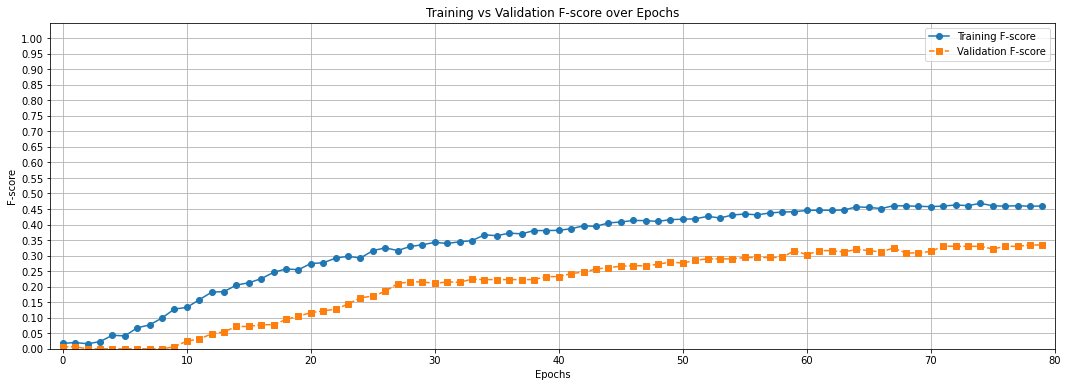

In [21]:
epochs = [i * check_step for i in range(0, len(t_history["loss"]))]
plt.figure(figsize=(18, 6))
plt.plot(epochs, t_history["fscore"], marker='o', linestyle='-', label='Training F-score')
plt.plot(epochs, v_history["fscore"], marker='s', linestyle='--', label='Validation F-score')
plt.xlabel("Epochs")
plt.ylabel("F-score")
plt.title("Training vs Validation F-score over Epochs")
plt.xlim(-1, max(epochs))
plt.ylim(0, 1.05)
plt.xticks([i for i in range(0, max(epochs) + 10, 10)])
plt.yticks([i/20 for i in range(21)])
plt.legend()
plt.grid(True)
plt.show()

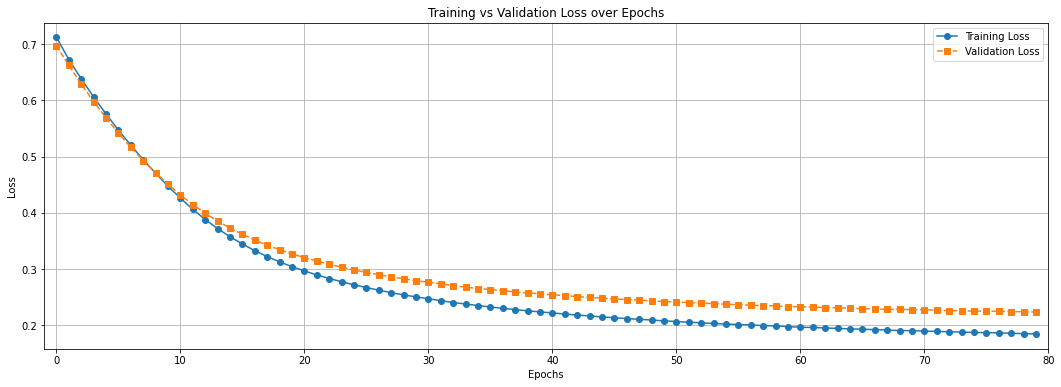

In [22]:
plt.figure(figsize=(18, 6))
plt.plot(epochs, t_history["loss"], marker='o', linestyle='-', label='Training Loss')
plt.plot(epochs, v_history["loss"], marker='s', linestyle='--', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xlim(-1, max(epochs))
plt.xticks([i for i in range(0, max(epochs) + 10, 10)])
plt.title("Training vs Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

## Your Task

We have used the deep regression model to perform smell event classification on the Smell Pittsburgh dataset. Now, check the previous two graphs again. What is the biggest problem with this model and the training procedure? How do you plan to improve it? Provide your answer below:

(Write your answer here)

Now, it is your turn to implement the plan that you provided above. Edit the model architecture and the hyper-parameters to improve the performance of your model. For example, you can try adding more layers, increasing the number of hidden units in the layers, tweaking the learning rate, tweaking the weight decay (i.e., regularization), etc. There is a set of hyper-parameters and a model architecture that can bring your model performance to f-score 0.5 (or above) at some point of time within 80 epochs, and then the performance will converge at about 0.45 f-score (or slightly more than that), such as the graph below:

![image.png](./images/pytorch-performance-example.png)

The result should be fairly stable, which means if you re-run the entire notebook for several times, the result should be roughly the same. Explain how you find this set of hyper-parameters and model architecture below.

(Write your answer here)

You can find the answer to the task in [this link](./answer.md). Do not look at the answer first. Instead, try to do the task by yourself, and then check the answer for reference.